In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import seaborn as sns
print(tf.__version__)
batch_size = 32
img_height = 180
img_width = 180
data_root="\\Users\\George\\Documents\\Python\\ADS CapStone\\aff_wild_annotations_bboxes_landmarks_new\\dataset_arousal\\"

2.4.1


In [2]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_root+'train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_root+'train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root+'train',
    seed=123,
    image_size=(img_height, img_width),
    batch_size = 200
)

Found 1435229 files belonging to 3 classes.
Using 1148184 files for training.
Found 1435229 files belonging to 3 classes.
Using 287045 files for validation.
Found 1435229 files belonging to 3 classes.


['high', 'low', 'neutral']


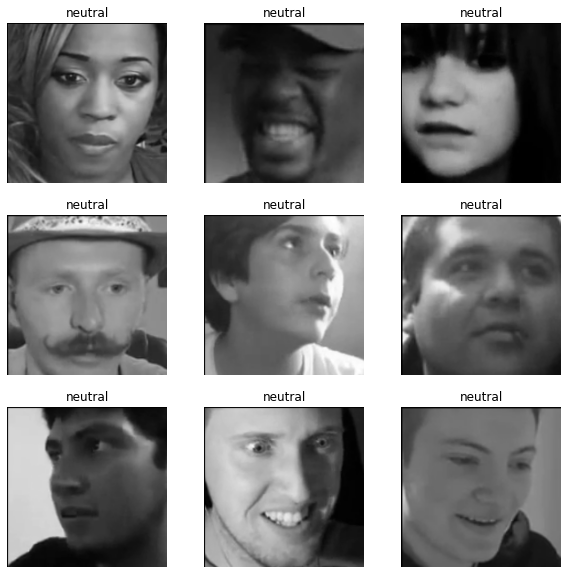

In [3]:

class_names = train_ds.class_names
print(class_names)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [5]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [6]:

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3)
])

In [7]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
35881/35881 [==============================] - 47188s 1s/step - loss: 0.3445 - accuracy: 0.8653 - val_loss: 0.1643 - val_accuracy: 0.9377
Epoch 2/5
35881/35881 [==============================] - 45786s 1s/step - loss: 0.1370 - accuracy: 0.9482 - val_loss: 0.1197 - val_accuracy: 0.9571
Epoch 3/5
35881/35881 [==============================] - 44625s 1s/step - loss: 0.0856 - accuracy: 0.9692 - val_loss: 0.1035 - val_accuracy: 0.9660
Epoch 4/5
35881/35881 [==============================] - 43951s 1s/step - loss: 0.0631 - accuracy: 0.9780 - val_loss: 0.0979 - val_accuracy: 0.9706
Epoch 5/5
35881/35881 [==============================] - 41739s 1s/step - loss: 0.0512 - accuracy: 0.9825 - val_loss: 0.0992 - val_accuracy: 0.9724


In [8]:

#result = model.evaluate(test_ds)
#dict(zip(model.metrics_names, result))

test_images = []
test_labels = []
predictions = []

for image, label in test_ds.take(1):
  test_images.append(image.numpy())
  test_labels.append(label.numpy())
  predictions.append(np.argmax(model.predict(test_images), axis=1))

test_labels = np.array(test_labels)
predictions = np.array(predictions)

y_true = test_labels

test_acc = sum(predictions[0] == y_true[0]) / len(y_true[0])
print(f'Test set accuracy: {test_acc:.0%}')

Consider rewriting this model with the Functional API.
Test set accuracy: 99%


['high', 'low', 'neutral']


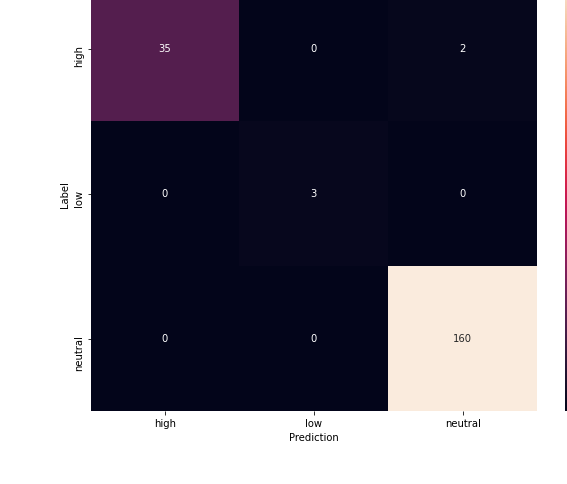

In [9]:

print(class_names)
confusion_mtx = tf.math.confusion_matrix(y_true[0], predictions[0]) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, yticklabels = class_names, xticklabels = class_names,annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [13]:
import pickle 
filepath = '\\Users\\George\\Documents\\Python\\ADS CapStone\\arousal_5epoch_unbalanced.pckl'
pickle.dump(model, open(filepath, 'wb'))


TypeError: cannot pickle 'weakref' object